Link to download this notebook from google drive:
https://drive.google.com/file/d/12OnklneVekJZvHQ9masU7EdS1_Flyxtn/view?usp=sharing

or on Gist:

https://github.com/MoGaber/CS146-Assignment-2.git

# Part 1

### Importing the necessary packages:

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

### Reading the data and visualizing it:

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


Text(0, 0.5, 'number of calls')

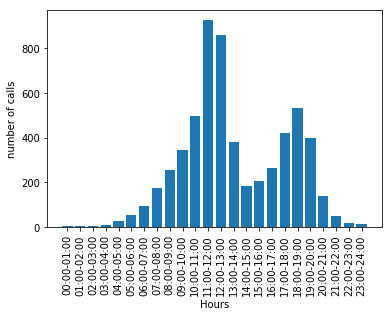

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Adding the hours of the day to one list and the number of calls per hour to another list
hours = []
number_calls = []
for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    hours.append(f'{hour:02}:00-{hour + 1:02}:00')
    number_calls.append(len(calls_in_hour))

    
#plotting a bar graph that shows the number of calls for each hour of the day.    
plt.xticks(rotation='vertical')
plt.bar(x = hours, height= number_calls)
plt.xlabel("Hours")
plt.ylabel("number of calls")


### Visualizing each hour of the day
In class, we took our likelihood function to be the exponential distribution because the histograms of hour 9  looks a lot like an instance of the exponential distribution and also because the exponential distribution has 1 parameter, namely the rate  𝜆. Here I will visualize the histograms for each hour of the day to see if the exponential distribution will be a good fit for them as well.

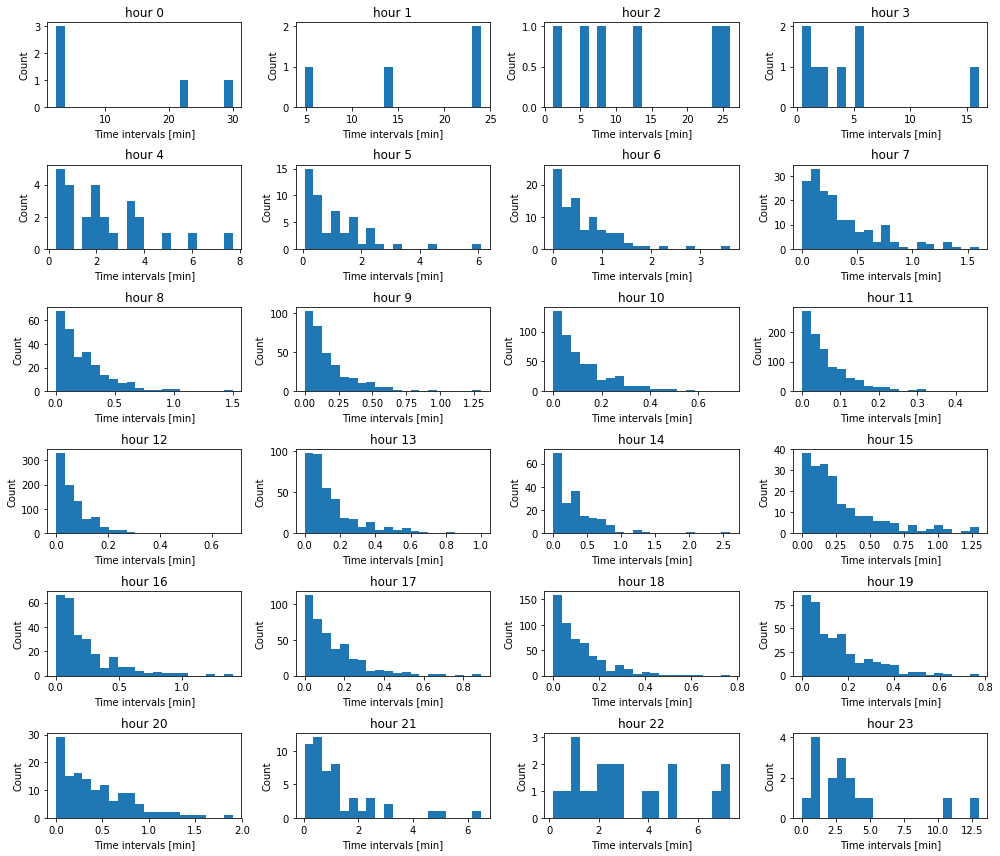

In [3]:
fig, axes =plt.subplots(6,4,figsize=(14,12)) #creating a 6x4 grid for my plots

# Plot histogram of the 24 hours
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    plt.subplot(6, 4, i+1)
    plt.hist(waiting_times_hour, bins=20)
    plt.xlabel('Time intervals [min]')
    plt.ylabel('Count')
    plt.title(f'hour {hour_index}')
fig.tight_layout()
plt.show()

### Choosing a plausible likelihood function
Looking at the histograms above, we see that most of the hours of the day actually look a lot like an instance of the exponential distribution except the fist few hours and the last two hours. The reason for the first and the last few hours to look this way is that these have few calls compared to the other hours of the day and so the time intervals between calls is scattered. Saying that and considering the fact that the exponential distribution has 1 parameter, namely the rate  𝜆, then we can choose the exponential distribution to be the likelihood function for each hour of the day.  

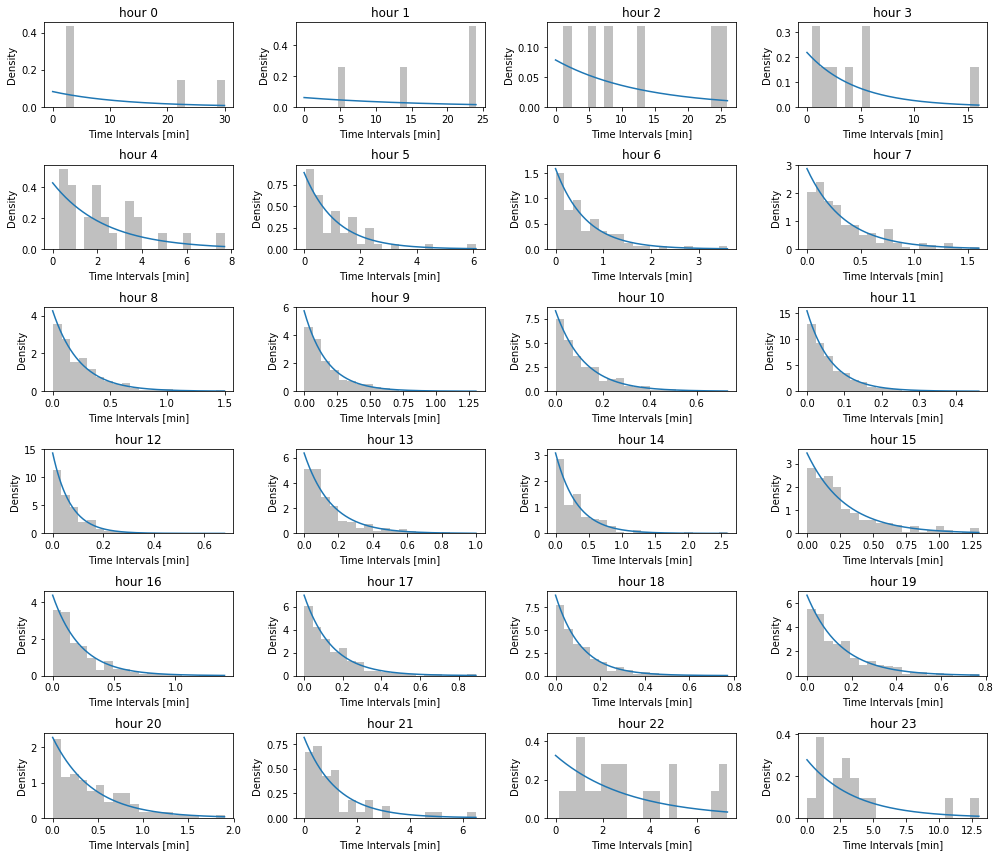

In [4]:
# Exponential distribution with maximum likelihood fit to the data 
#we will take our initial guess for the rate (called the maximum likelihood estimate) as the average of the data.

fig, axes =plt.subplots(6,4,figsize=(14,12)) #grid of 6x4 to plot a figure for each hour
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    lambda_ = 1 / np.mean(waiting_times_hour) #our initial guess for the rate
    distribution = sts.expon(scale=1/lambda_) #the exponential distribution
    
    plt.subplot(6, 4, i+1)# a plot for each hour of the day
    plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
    x = np.linspace(0, max(waiting_times_hour), 200) 
    y = distribution.pdf(x) #pdf of the exp distribution
    plt.plot(x, y)
    plt.xlabel('Time Intervals [min]')
    plt.ylabel('Density')
    plt.title(f'hour {hour_index}')
  

fig.tight_layout()
plt.show()

As expected, the exponential distribution is a good guess for most of the hours as shown above.

### Defining our functions for likelihood, prior, and posterior
For prior, we are using gamma distribution with alpha = 1 and Beta = 0.25, and we will use Bayesian inference to compute the posterior.

In [5]:

# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set(datum).
def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)


# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density
def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)



#the below posterior function is based on Bayesian inference, it's explained in details in the extra part below.
def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior


### Plotting the inference results for each hour of the day:

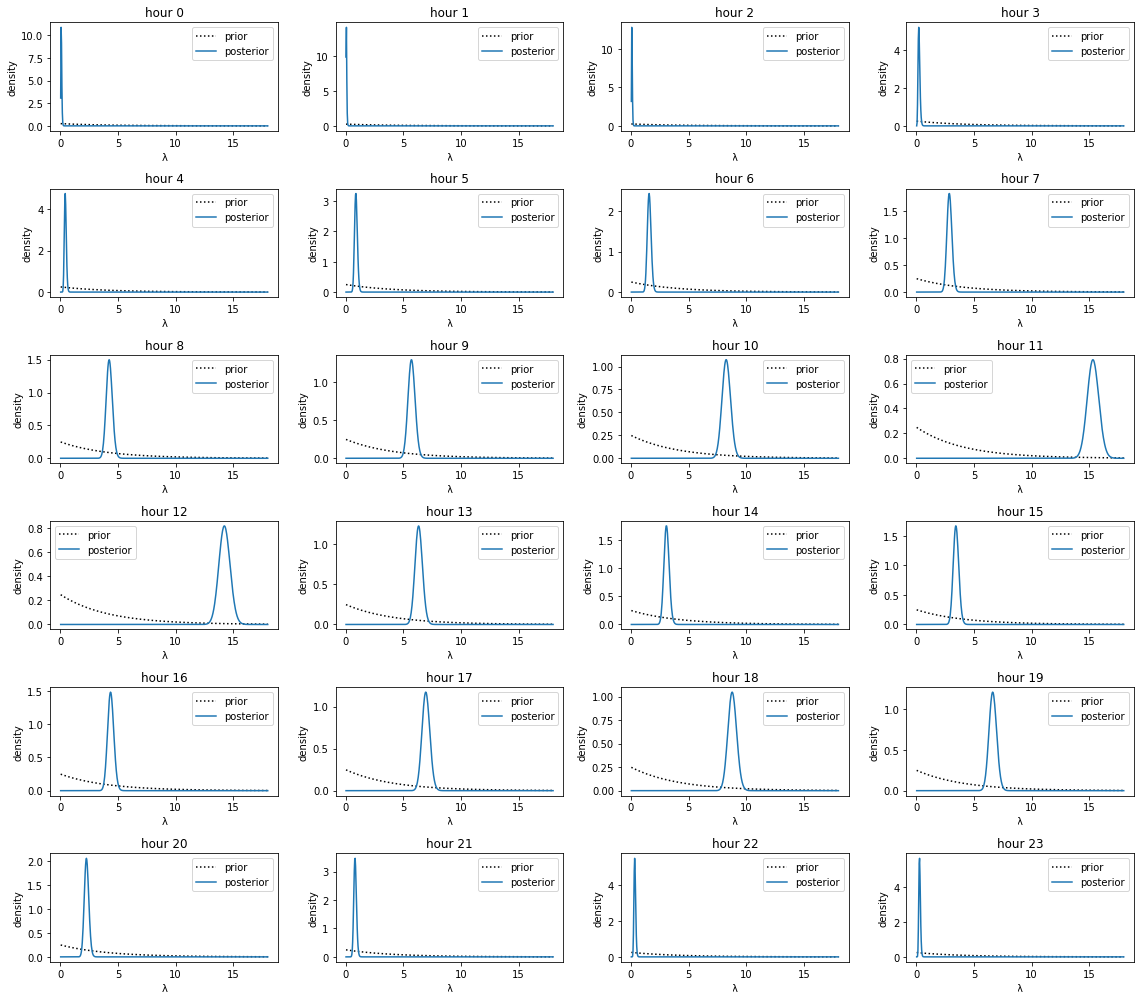

In [6]:
lambdas = np.linspace(0, 18, 501)[1:] 
fig, axes =plt.subplots(6,4,figsize=(16,14))

#plotting the prior and posterior on the same axes
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    
    plt.subplot(6, 4, i+1)
    plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
    plt.plot(lambdas, posterior, label='posterior')
    plt.xlabel('λ')
    plt.ylabel('density')
    plt.title(f'hour {hour_index}')
    plt.legend() 

    
  
fig.tight_layout()
plt.show()

We notice that the first and last few hours have their posterior centered close to the zero because they have very few number of calls per minute. Also we notice that the resultant distribution looks this way because it comes by multiplying the likelihood function by the prior function. We also notice that it's a gamma distribution because of using a prior conjugate of gamma.

### Computing confidence intervals for each hour of the day:

In [7]:
 '''
    This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
def compute_percentile(parameter_values, distribution_values, percentile):
  
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

Posterior 98% interval for hour 0: [0.036, 0.21599999999999997] calls per minute
Posterior 98% interval for hour 1: [0.036, 0.18] calls per minute
Posterior 98% interval for hour 2: [0.036, 0.18] calls per minute
Posterior 98% interval for hour 3: [0.072, 0.46799999999999997] calls per minute
Posterior 98% interval for hour 4: [0.252, 0.6479999999999999] calls per minute
Posterior 98% interval for hour 5: [0.612, 1.188] calls per minute
Posterior 98% interval for hour 6: [1.224, 1.9799999999999998] calls per minute
Posterior 98% interval for hour 7: [2.376, 3.384] calls per minute
Posterior 98% interval for hour 8: [3.6359999999999997, 4.896] calls per minute
Posterior 98% interval for hour 9: [5.004, 6.444] calls per minute
Posterior 98% interval for hour 10: [7.4159999999999995, 9.144] calls per minute
Posterior 98% interval for hour 11: [14.184, 16.523999999999997] calls per minute
Posterior 98% interval for hour 12: [13.139999999999999, 15.371999999999998] calls per minute
Posterio

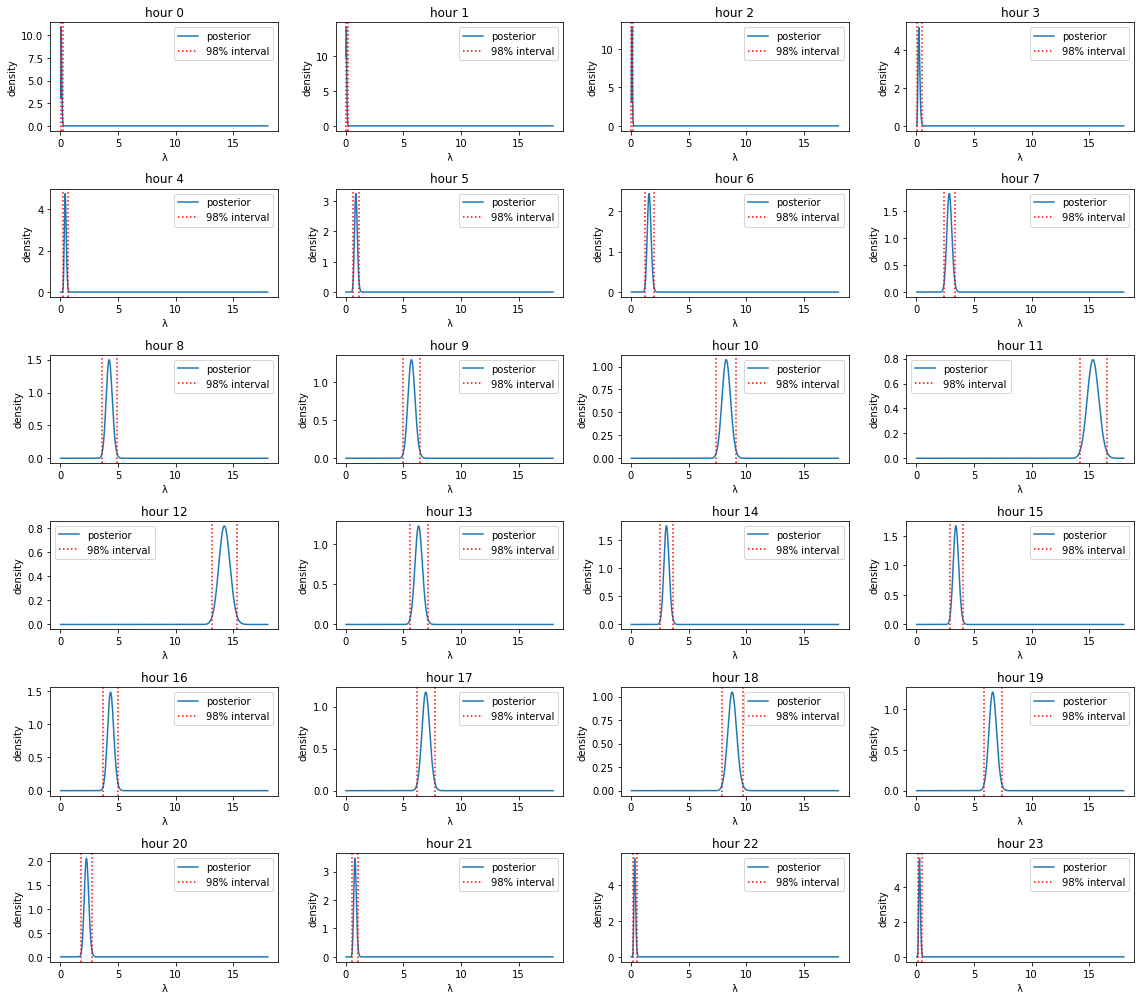

In [8]:
#visualizing the 98% confidence intervals for each hour of the day
fig, axes =plt.subplots(6,4,figsize=(16,14))

for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]# 98% percentiles for each hour
    
    plt.subplot(6, 4, i+1)
    plt.plot(lambdas, posterior, label='posterior')
    plt.axvline(percentiles[0], color='red', linestyle=':', label='98% interval')
    plt.axvline(percentiles[1], color='red', linestyle=':')
    plt.xlabel('λ')
    plt.ylabel('density')
    plt.title(f'hour {hour_index}')
    plt.legend()
    print(f'Posterior 98% interval for hour {hour_index}:', percentiles, 'calls per minute')

    
fig.tight_layout()
plt.show()

### Checking our results
Here we will use the posterior mean of  𝜆 to plot an exponential distribution on top of the data histogram for each hour.

Expected value for hour 0: λ = 0.10137679199634492 calls per minute
Expected value for hour 1: λ = 0.08060996494462386 calls per minute
Expected value for hour 2: λ = 0.0941949462576493 calls per minute
Expected value for hour 3: λ = 0.24266180364705403 calls per minute
Expected value for hour 4: λ = 0.4423328964613372 calls per minute
Expected value for hour 5: λ = 0.9033121445299431 calls per minute
Expected value for hour 6: λ = 1.5911875564257962 calls per minute
Expected value for hour 7: λ = 2.8810069616056153 calls per minute
Expected value for hour 8: λ = 4.256924597345014 calls per minute
Expected value for hour 9: λ = 5.728695915357029 calls per minute
Expected value for hour 10: λ = 8.2794764772077 calls per minute
Expected value for hour 11: λ = 15.342752162625342 calls per minute
Expected value for hour 12: λ = 14.250688383067258 calls per minute
Expected value for hour 13: λ = 6.34942318060014 calls per minute
Expected value for hour 14: λ = 3.094053744378928 calls per mi

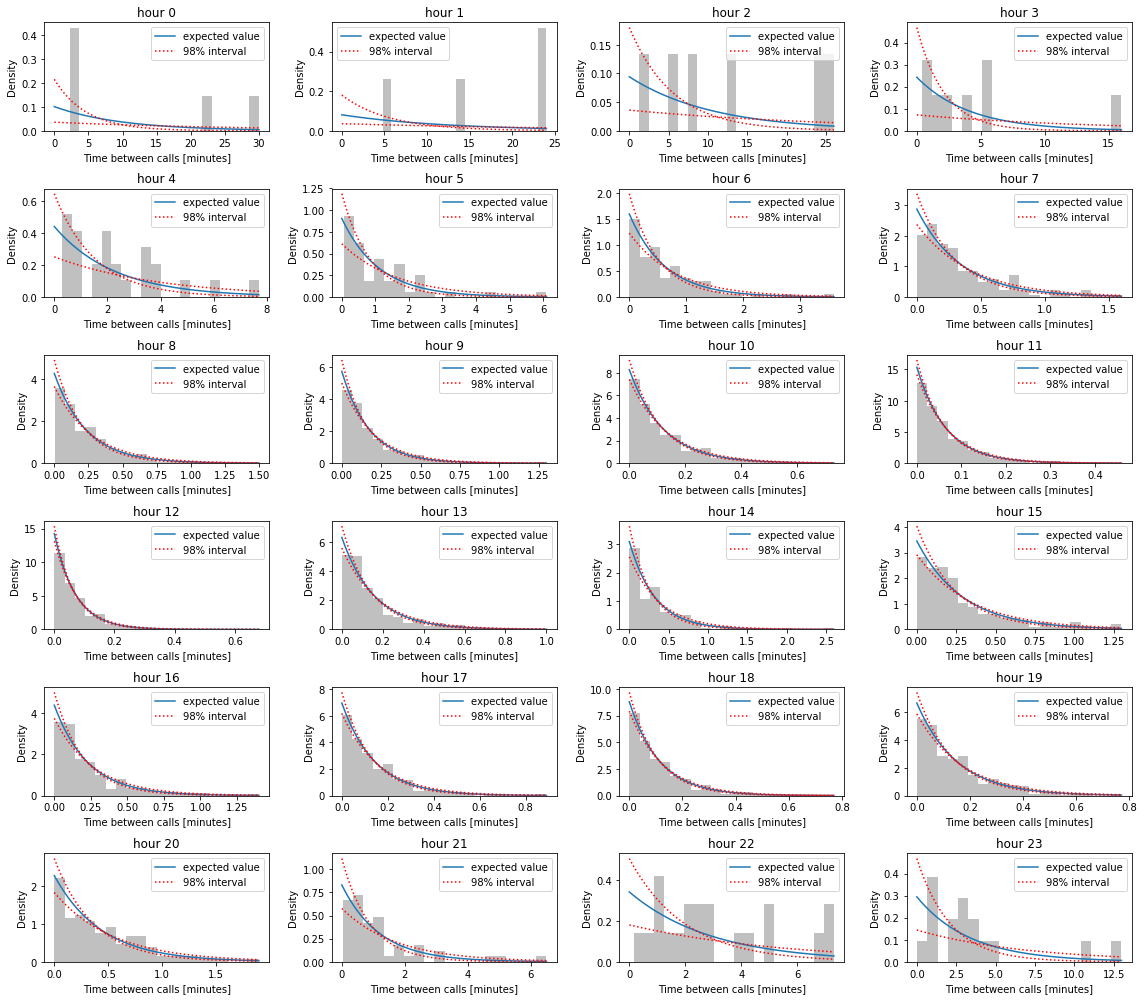

In [9]:
fig, axes =plt.subplots(6,4,figsize=(16,14))
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas) # the posterior expected value of λ
    print(f'Expected value for hour {hour_index}: λ =', lambda_, 'calls per minute')
    
    plt.subplot(6, 4, i+1)
    plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
    x = np.linspace(0, max(waiting_times_hour), 200)
    plt.plot(x, sts.expon.pdf(x, scale=1/lambda_), label='expected value')
    plt.plot(x, sts.expon.pdf(x, scale=1/percentiles[0]), color='red', linestyle=':', label='98% interval')
    plt.plot(x, sts.expon.pdf(x, scale=1/percentiles[1]), color='red', linestyle=':')
    plt.xlabel('Time between calls [minutes]')
    plt.ylabel('Density')
    plt.title(f'hour {hour_index}')
    plt.legend()



fig.tight_layout()
plt.show()

We note from the above that our models provided a good fit for most of the hours of the day (except the first and last few because they have very few data points).  

## Part 2: Presenting the results graphically

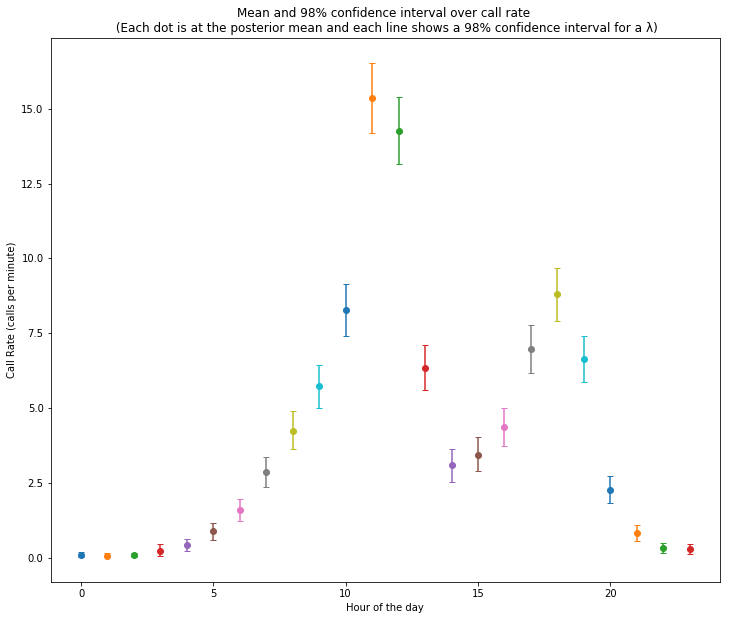

In [10]:
#plotting the error bar for each confidence interval that we got
#Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ

plt.figure(figsize=(12, 10))
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
    plt.errorbar(i, lambda_, yerr =[[lambda_ - percentiles[0]],[percentiles[1]-lambda_]]  , fmt='o', capsize=3)
    plt.xlabel('Hour of the day')
    plt.ylabel("Call Rate (calls per minute)")


plt.title('Mean and 98% confidence interval over call rate \n (Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ)')
plt.show()

## Part 3: Summary

Using the data about the time interval between calls that we were provided, we conducted the analysis above. our analysis results indicate that on average each hour of the day should have the number of calls shown in the figure below:

Text(0.5, 1.0, 'The average number of calls per minute for hours of the day')

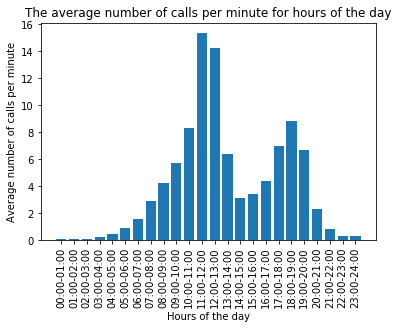

In [11]:
lambda_s = []
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas) # the posterior expected value of λ
    lambda_s.append(lambda_)

plt.xticks(rotation='vertical')
plt.bar(x = hours, height= lambda_s)
plt.xlabel("Hours of the day")
plt.ylabel("Average number of calls per minute")
plt.title("The average number of calls per minute for hours of the day")

That graph shows that 09:00 through 20:00 will be the busiest time of the day with hours 11:00 and 12:00 being the busiest which means that around that time(hour 11:00 for example) on average, you can expect to get 15 calls per minute. These are however averages, to be more certain about the number of calls per minute that you should expect, we conducted an analysis and obtained confidence intervals. These confindence intervals are ranges that we are 98% certain that they contain the real rate of calls per minute. You can find the intervals (ranges) for each hour of the day in the graph below: 

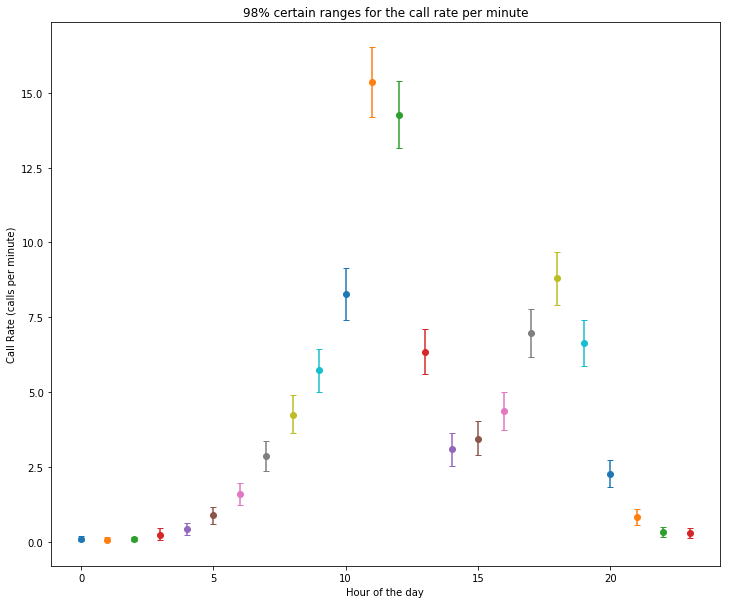

In [12]:
#plotting the error bar for each confidence interval that we got
#Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ

plt.figure(figsize=(12, 10))
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
    plt.errorbar(i, lambda_, yerr =[[lambda_ - percentiles[0]],[percentiles[1]-lambda_]]  , fmt='o', capsize=3)
    plt.xlabel('Hour of the day')
    plt.ylabel("Call Rate (calls per minute)")


plt.title('98% certain ranges for the call rate per minute')
plt.show()

## 2. Stretch Goal: Explaining the function compute_posterior
In the cells below, I will explain what each line in the function does.

In [13]:
def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

- "log_prior = np.log(prior(parameter_values))":

Here we are passing the lambdas values to the prior function in order to get the probability mass for each lambda. 
We then take the log of these probability masses because when we multiply priors by likelihoods, results can become very large or very small, causing numerical overflow or underflow in Python. Taking logarithms avoids this problem.

- " log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values]) "
        
This line is calculating the likelihood of obtaining each data point using one parameter then it get the logs of these
likelihoods and sum them. Summing logs of probabilities is just like multiplying these probabilities, so this line is basically multiplying the likelihoods of different data points using one parameter because the likelihoods are independent and identically distributed random variables. Then it passes another parameter using the for loop and calculates the likelihoods for each data point using that parameter and multiply them (sum their logs). At the end, each of these likelihoods obtained using the different parameters are saved in a numpy array.

- "unnormalized_log_posterior = log_prior + log_likelihood" 

This line is multiplying the priors and the likelihoods. As we said above, summing logs of probabilities is the same as multiplying these probabilties.

- "unnormalized_log_posterior -= max(unnormalized_log_posterior)""

This line is subtracting each value in the unnormalized_log_posterior from the max value in that array. When we do that, we are nicely scaling the values of the log posterior and making the maximum log posterior zero.

- "unnormalized_posterior = np.exp(unnormalized_log_posterior)"

now we are exponentiating to remove the logs


- "area = sp.integrate.trapz(unnormalized_posterior, parameter_values)"
- "posterior = unnormalized_posterior / area"
   

subtracting each value in the unnormalized_log_posterior from the max value in that array scaled the values of the log posterior and made the maximum log posterior equal to zero but it didn't normalize our posterior so we calculate the area and divide the unnormalized posterior by it in order to normalize it and have a total probability of 1

### The following is an example to how not taking logarithms would produce the wrong posterior
Since logs help us avoid the problem of overflow when the values are very large, I will consider a hypothetical situation in which the waiting time is super large (hypothetically) to show how not taking logs will cause a numerical overflow:

In [14]:
data = waiting_times_per_hour[9]*1000 #hypothetical situation when the waiting time is super large

In [15]:
def compute_posterior_nologs(parameter_values, prior, likelihood, data):
    prior = prior(parameter_values) #removed the log
    likelihood = np.array([
        np.prod((likelihood(param, data))) #removed the log and replaced np.sum with np.prod
        for param in parameter_values])
    unnormalized_posterior = prior * likelihood
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

C:\Users\gaber\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\gaber\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


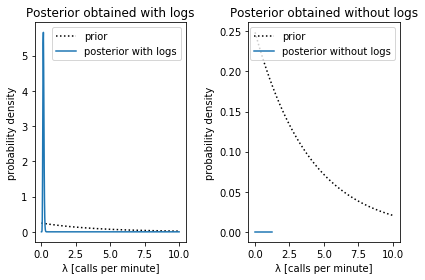

In [16]:
lambdas = np.linspace(0, 10, 501)[1:]

posterior_with_logs = compute_posterior(lambdas, prior, likelihood, data)#using the original function with logs

posterior_nologs = compute_posterior_nologs(lambdas, prior, likelihood, data)#using the function without logs

#plot posterior with logs
fig, axes =plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior with logs')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Posterior obtained with logs')
plt.legend()

#plot posterior without logs
plt.subplot(1, 2, 2)
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior_nologs, label='posterior without logs')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Posterior obtained without logs')
plt.legend()


fig.tight_layout()
plt.show()

We notice from the two graphs above that the posterior obtained without using logs faced a numerical overflow error while the one with logs was just fine.

### One more stretch
We notice that the prior that we chose above is actually a prior conjugate for the exponential likelihood distribution and that's why we obtained a gamma distribution for the posterior. Knowing that could save us a lot of steps done above (like not using the compute_posterior function and not integrating to obtain the posterior mean). 

In [17]:
#calculating the posterior parameters using the equation from Wikipedia
alpha_prior = 1
Beta_prior = 0.25
def posterior(alpha_prior, Beta_prior, data):
    Alpha_posterior = alpha_prior+len(data)
    Beta_posterior = Beta_prior+ np.sum([data_points for data_points in data])
    posterior_distribution = sts.gamma(Alpha_posterior, scale = 1/Beta_posterior)
    return posterior_distribution

Then we can plot the distribution easily as following:

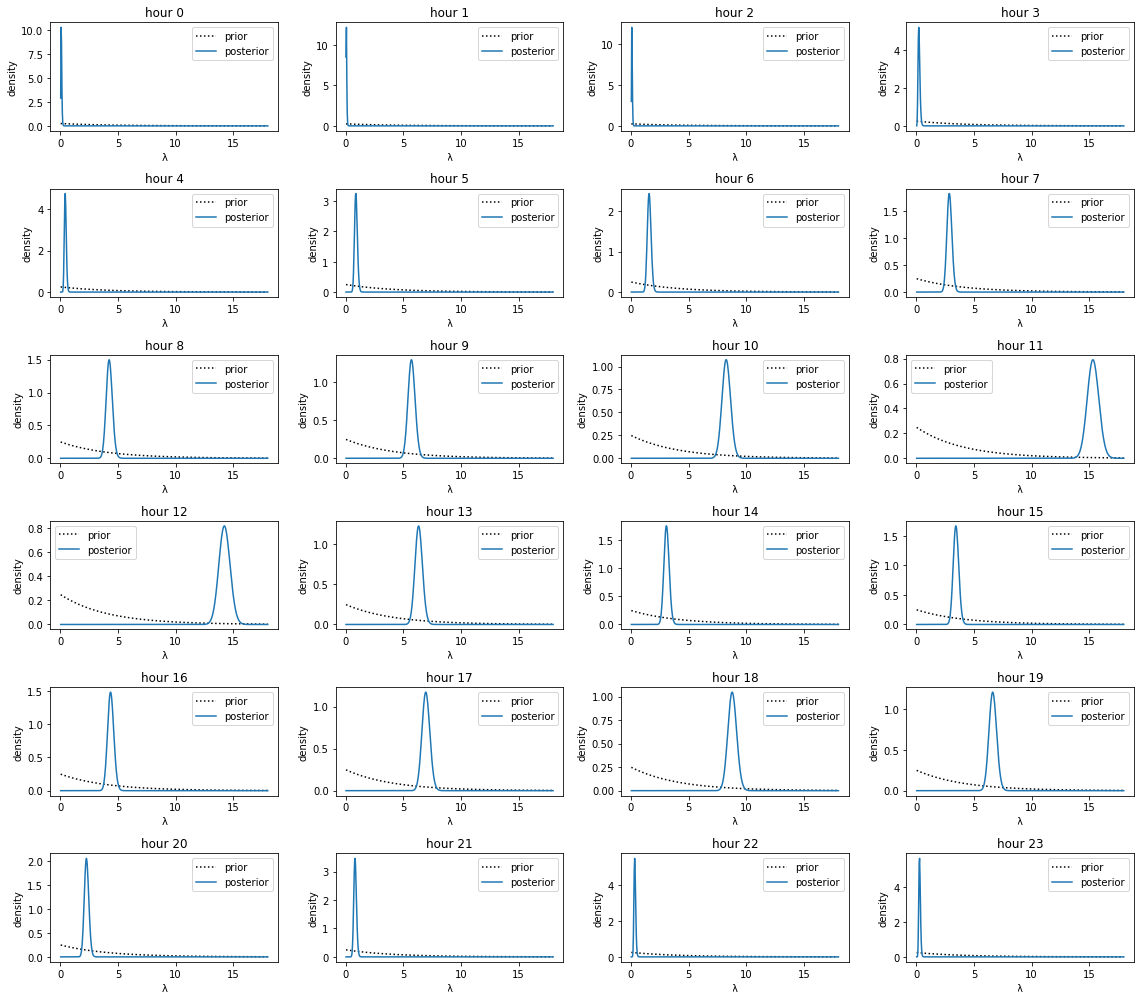

In [18]:
lambdas = np.linspace(0, 18, 501)[1:]
fig, axes =plt.subplots(6,4,figsize=(16,14))
for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior_distribution = posterior(alpha_prior, Beta_prior, waiting_times_hour)
    plt.subplot(6, 4, i+1)
    plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
    plt.plot(lambdas, posterior_distribution.pdf(lambdas), label='posterior')
    plt.xlabel('λ')
    plt.ylabel('density')
    plt.title(f'hour {hour_index}')
    plt.legend()

    
fig.tight_layout()
plt.show()

and the confidence intervals can be obtained easily as following:

Posterior 98% interval for hour 0: (0.029195167380248507, 0.21436604501664638) calls per minute
Posterior 98% interval for hour 1: (0.019076899031970223, 0.17307420700189677) calls per minute
Posterior 98% interval for hour 2: (0.03032156839725289, 0.18959816356976447) calls per minute
Posterior 98% interval for hour 3: (0.09456606768903456, 0.4692006704597609) calls per minute
Posterior 98% interval for hour 4: (0.2686225981643922, 0.6640626794421454) calls per minute
Posterior 98% interval for hour 5: (0.6421343789956387, 1.213606928858222) calls per minute
Posterior 98% interval for hour 6: (1.2344384081020556, 1.9976760504278792) calls per minute
Posterior 98% interval for hour 7: (2.3973780111823753, 3.413310073289663) calls per minute
Posterior 98% interval for hour 8: (3.6614177680977065, 4.901514584363022) calls per minute
Posterior 98% interval for hour 9: (5.0366690101543945, 6.469408110416777) calls per minute
Posterior 98% interval for hour 10: (7.440076273593514, 9.1678658

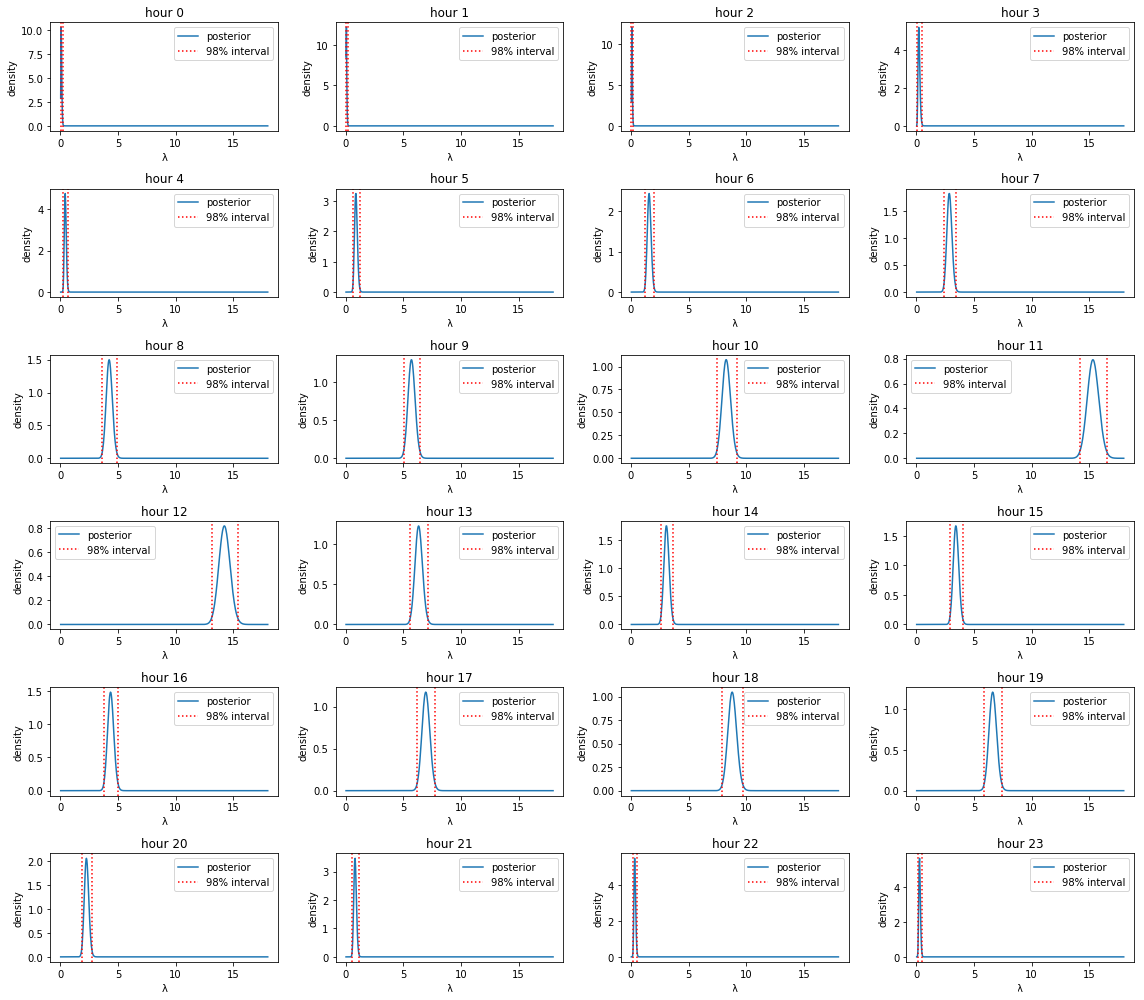

In [19]:
fig, axes =plt.subplots(6,4,figsize=(16,14))

for i in range(24):
    hour_index = i
    waiting_times_hour = waiting_times_per_hour[hour_index]
    posterior_distribution = posterior(alpha_prior, Beta_prior, waiting_times_hour)
    percentiles = posterior_distribution.interval(.98)# 98% percentiles for each hour
    
    plt.subplot(6, 4, i+1)
    plt.plot(lambdas, posterior_distribution.pdf(lambdas), label='posterior')
    plt.axvline(percentiles[0], color='red', linestyle=':', label='98% interval')
    plt.axvline(percentiles[1], color='red', linestyle=':')
    plt.xlabel('λ')
    plt.ylabel('density')
    plt.title(f'hour {hour_index}')
    plt.legend()
    print(f'Posterior 98% interval for hour {hour_index}:', percentiles, 'calls per minute')

    
fig.tight_layout()
plt.show()

and the posterior mean of 𝜆 for each hour can be easily obtained without integration using the expected value equation of the gamma distribution: E(x) = Alpha/Beta 

In [20]:
for i in range(24):
    data = waiting_times_per_hour[i]
    Alpha_posterior = alpha_prior+len(data)
    Beta_posterior = Beta_prior+ np.sum([data_points for data_points in data])
    mean = Alpha_posterior / Beta_posterior
    print(f'Expected value for hour {i}: λ =', mean, 'calls per minute')

Expected value for hour 0: λ = 0.09811937857726902 calls per minute
Expected value for hour 1: λ = 0.07457121551081283 calls per minute
Expected value for hour 2: λ = 0.09108653220559532 calls per minute
Expected value for hour 3: λ = 0.24265300620113237 calls per minute
Expected value for hour 4: λ = 0.44233289646133683 calls per minute
Expected value for hour 5: λ = 0.9033121445299431 calls per minute
Expected value for hour 6: λ = 1.5911875564257958 calls per minute
Expected value for hour 7: λ = 2.8810069616056144 calls per minute
Expected value for hour 8: λ = 4.256924597345015 calls per minute
Expected value for hour 9: λ = 5.728695915357028 calls per minute
Expected value for hour 10: λ = 8.279476477207702 calls per minute
Expected value for hour 11: λ = 15.342752954309281 calls per minute
Expected value for hour 12: λ = 14.250688383069164 calls per minute
Expected value for hour 13: λ = 6.349423180600141 calls per minute
Expected value for hour 14: λ = 3.094053744378928 calls p

#### by doing that, we have solved the assignment twice using two different ways.

## More Practical Excercies

### 1.a

In [21]:
normal_distribtution = sts.norm(loc = 100, scale=10)
sample = normal_distribtution.rvs(size = 1000)

according to the 68–95–99.7 rule, the probability that an observation is at max two standard deviation from the mean is 95%, so the probability that a value is at least two standard deviation from the mean is 100-95 = .05%, so .05*1000 = 50 numbers should be two standard deviation or more from the mean. We can check that with python as following:

In [22]:
mean = 100
SD = 10
count = 0
for number in sample:
    if number >= mean+2*SD or number <= mean-2*SD:
        count+=1
print("number of values that are two standard deviation or more away from the mean:", count) 

number of values that are two standard deviation or more away from the mean: 54


### 1.b

In [23]:
import random
tosses = []
for _ in range(50):
    tosses.append(random.choice(["Head", "Tail"]))
print("number of heads ", tosses.count('Head'))
#I expect to have 50% * 50 = 25 Heads

number of heads  24


### 1.c

In [24]:
rolls = []
for _ in range(1000):
    rolls.append(random.randint(1, 6))

print("Number of 6s that I get", rolls.count(6))
#I expect to get (1/6 * 1000)

Number of 6s that I get 171


### 1.d

In [25]:
normal_dis = sts.norm(loc = 0, scale = 2)
#area to the right of 1.5 is the probability of obtaining a number larger than 1.5 from that distribution:
1-normal_dis.cdf(1.5)

0.22662735237686826

### 2.a

In [26]:
y = []
for _ in range(5000): #getting 5000 counts of y
    rolls = []
    for _ in range(1000): #making 1000 rolls of a fair die 
        rolls.append(random.randint(1, 6)) #our fair die
    y.append(rolls.count(6)) #counting the 6s in each of the 1000 rolls

Text(0, 0.5, 'Frequency')

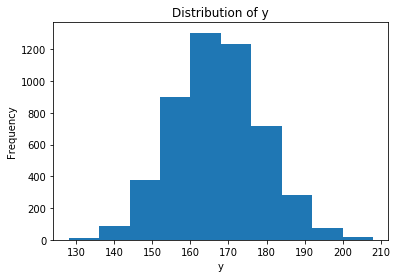

In [27]:
#plotting the distribution of y
import matplotlib.pyplot as plt
plt.hist(y)
plt.title("Distribution of y")
plt.xlabel('y')
plt.ylabel('Frequency')

### 2.b

In [28]:
import numpy as np
mean, SD = np.mean(y), np.std(y) 
norm_dist = sts.norm(loc = mean, scale = SD) #building a normal distribution using the mean and SD of y

print(f" Approximate 5% points for y: {sts.norm.interval(0.05, loc=mean, scale=SD)} ")
print(f" Approximate 25% points for y: {sts.norm.interval(0.25, loc=mean, scale=SD)} ")
print(f" Approximate 50% points for y: {sts.norm.interval(0.5, loc=mean, scale=SD)} ")
print(f" Approximate 75% points for y: {sts.norm.interval(0.75, loc=mean, scale=SD)} ")
print(f" Approximate 95% points for y: {sts.norm.interval(0.95, loc=mean, scale=SD)} ")

 Approximate 5% points for y: (165.86825341891588, 167.32094658108414) 
 Approximate 25% points for y: (162.90372924877215, 170.28547075122788) 
 Approximate 50% points for y: (158.7818349353546, 174.40736506464543) 
 Approximate 75% points for y: (153.26984680912435, 179.91935319087568) 
 Approximate 95% points for y: (143.89190045278497, 189.29729954721506) 


## 3
Please find the solution to this question in the link below:

https://docs.google.com/document/d/10zLKd7vVq1HR0Gu9p_1Go3pdHUriQ-l88Wqq6VzikmQ/edit?usp=sharing

The code used to calculate the confidence intervals:

In [29]:
#confidence interval for posterior with n =10
sts.norm(loc = 75.652,scale= 3.15).interval(.95)

(69.47811344869883, 81.82588655130117)

In [30]:
#confidence interval for posterior predictive with n =10
sts.norm(loc = 75.652,scale= 10.485).interval(.95)

(55.101777622097536, 96.20222237790247)

In [31]:
#confidence interval for posterior  with n =100

sts.norm(loc = 75.1,scale= .9995).interval(.95)

(73.14101599745221, 77.05898400254777)

In [32]:
#confidence interval for posterior predictive with n =100

sts.norm(loc = 75.1,scale= 10.049).interval(.95)

(55.40432191935699, 94.795678080643)